In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")


  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


In [2]:
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

true

In [38]:
rod2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,
        :isSource => Bool,
        :S=>Float64   
    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        
        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2+Fijy^2)

        end

        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) 
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) 
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 

        if isSource
            dt(x) = 0
            dt(y) = 0
            dt(vx) = 0
            dt(vy) = 0
            dt(θ) = 0
            dt(ω) = 0
        end

    end,

    agentRule = quote

        if tTumble < t && active 
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active 
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((2 -mm ) * τTumble) 
        end

        xmin = simBox[1,1] + l/2     #Nou intent de delimitar box
        xmax = simBox[1,2] - l/2
        ymin = simBox[2,1] + l/2
        ymax = simBox[2,2] - l/2

        if x < xmin
            x = xmin
            vx = 0 #Assegurar que els bacteris parin a la pared, pareds elastiques serien amv vx = -vx  
        elseif x > xmax
            x = xmax
            vx = 0
        end

        if y < ymin
            y = ymin
            vy = 0
        elseif y > ymax
            y = ymax
            vy = 0
        end

        if isSource
            mm += S
        end
    
    end,
    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium*(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,
    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	τTumble (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin
    if tTumble < t && active
        vx__ = 0
        vy__ = 0
        active__ = false
        ω__ += ωTumble
        tTumble__ += 1.0
    elseif tTumble < t && !active
        ω__ = 0
        active__ = true
        tTu

In [39]:
com = Community(
    rod2DChemotaxis,
    N=75,
    dt=0.1,
    simBox=[-20 20;-20 20.],
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 1
com.τTumble = 2

com.ωTumble = 1
com.DMedium = 0.9

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)

com.active = true

src = 1

com.active[src] = false 
com.isSource .= false
com.isSource[src] = true

com.x[src] = 0.0
com.y[src] = 0.0
com.vx[src] = 0.0
com.vy[src] = 0.0
com.S = 0.0
com.S[src] = 2.0

2.0

In [40]:
evolve!(com, steps = 1000, saveEach = 10)

In [3]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

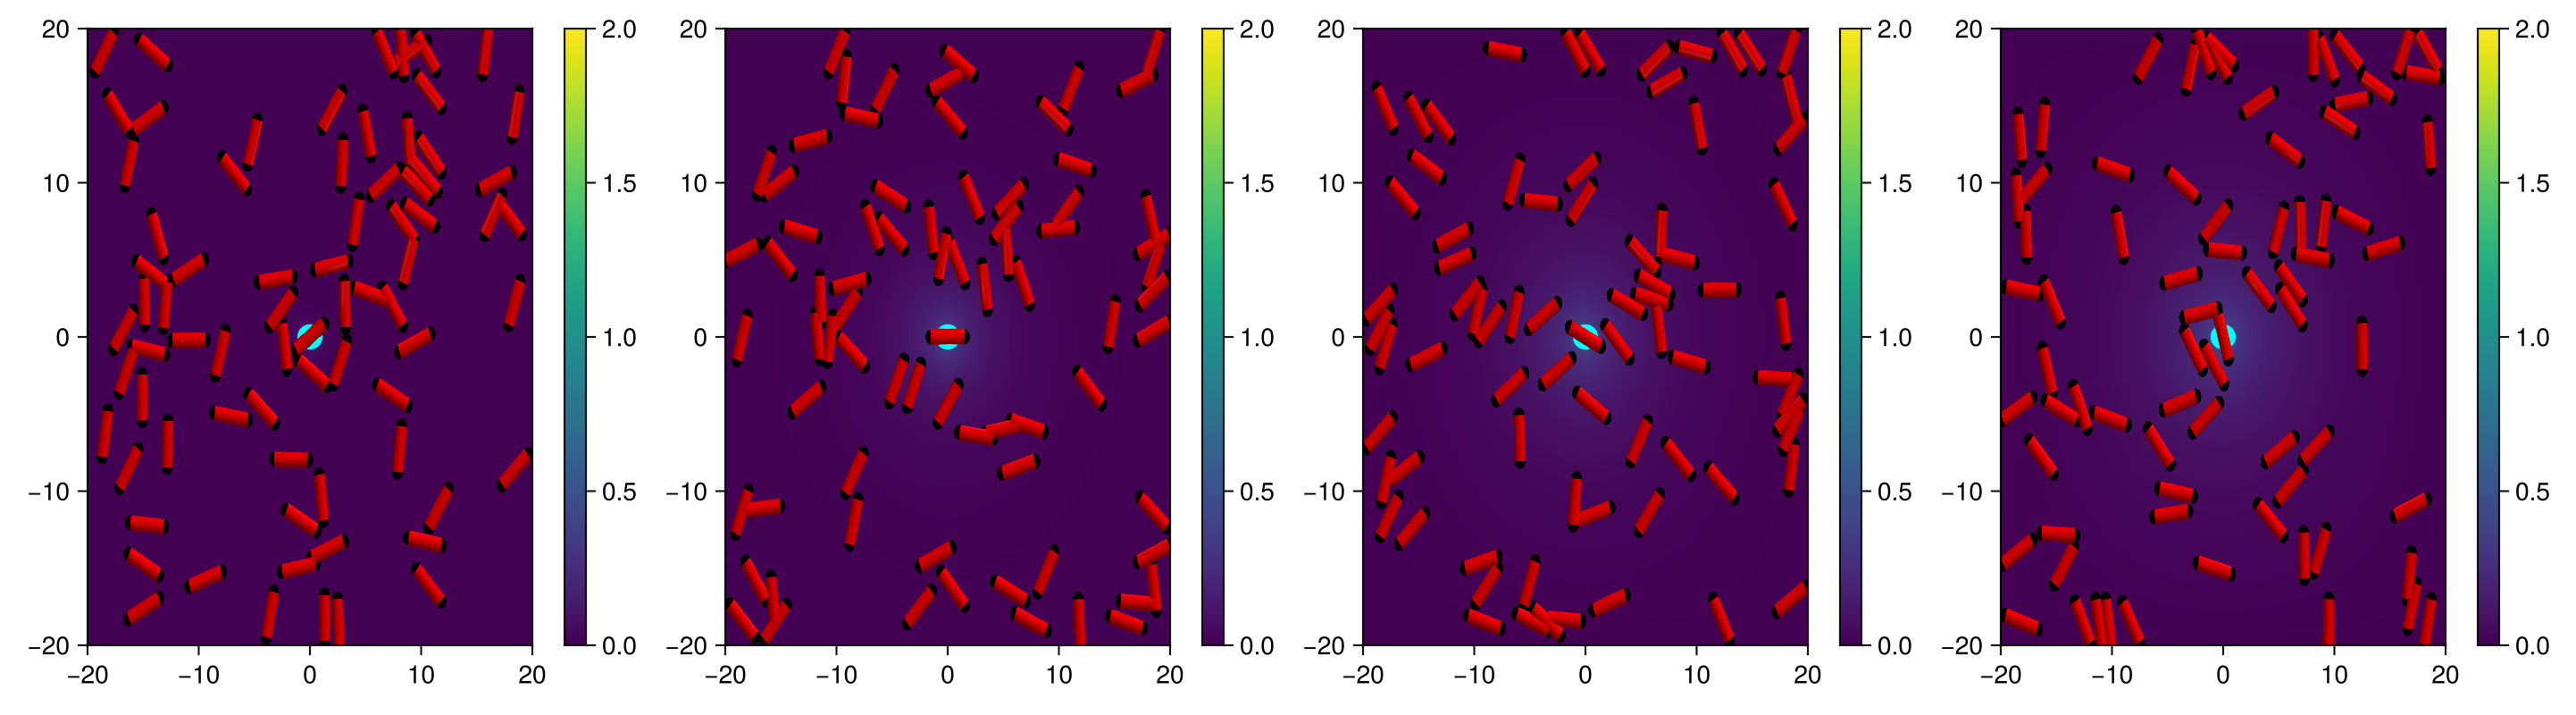

GLMakie.Screen(...)

In [42]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

## Difusióoo


In [ ]:
rod2DChemotaxis_2 = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,
        :isSource => Bool,
        :S=>Float64   
    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        
        fx = 0
        fy = 0
        W = 0
        pressure = 0
        @loopOverNeighbors i2 begin
            
            Fijx, Fijy, Wij = CBMModels.rodForces(
                                    x,y,d,l,theta,vx,vy,m,
                                    x[i2],y[i2],d[i2],l[i2],theta[i2],vx[i2],vy[i2],m[i2],
                                    kn,γn,γt,μcc,μcw
                                )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2+Fijy^2)

        end

        dt(x) =  vx 
        dt(y) =  vy 
        dt(vx) =  -β*vx+fx/m + active * fChem * cos(theta) 
        dt(vy) =  -β*vy+fy/m + active * fChem * sin(theta) 
        dt(theta) =  ω
        dt(ω) =  W/(m*(d+l)^2/12+m*d^2)-βω*ω 

        if isSource
            dt(x) = 0
            dt(y) = 0
            dt(vx) = 0
            dt(vy) = 0
            dt(θ) = 0
            dt(ω) = 0
        end

    end,

    agentRule = quote

        if tTumble < t && active 
            vx = 0
            vy = 0
            active = false
            ω += ωTumble
            tTumble += 1.
        elseif tTumble < t && !active 
            ω = 0
            active = true
            tTumble += CBMDistributions.exponential((2 - mm ) * τTumble) 
        end

        xmin = simBox[1,1] + l/2     #Nou intent de delimitar box
        xmax = simBox[1,2] - l/2
        ymin = simBox[2,1] + l/2
        ymax = simBox[2,2] - l/2

        if x < xmin
            x = xmin
            vx = 0 #Assegurar que els bacteris parin a la pared, pareds elastiques serien amv vx = -vx  
        elseif x > xmax
            x = xmax
            vx = 0
        end

        if y < ymin
            y = ymin
            vy = 0
        elseif y > ymax
            y = ymax
            vy = 0
        end

        if isSource
            mm += S
        end
    
    end,
    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium*(@∂2(1, mm)+ @∂2(2, mm)) - delta*mm
        end
    end,
    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	βω (Float64 model)
	τTumble (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm))
end

agentRule
 begin
    if tTumble < t && active
        vx__ = 0
        vy__ = 0
        active__ = false
        ω__ += ωTumble
        tTumble__ += 1.0
    elseif tTumble < t && !active
        ω__ = 0
        active__ = true
        tTu

In [25]:
com_2 = Community(
    rod2DChemotaxis_2,
    N=75,
    dt=0.1,
    simBox=[-20 20;-20 20.],
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com_2.kn = 2E6      * (m*g/d)
com_2.γn = 2.2E2    * sqrt(g/d)
com_2.γt = 2.2E2    * sqrt(g/d)
com_2.μcc = 0.1
com_2.μcw = 0.8
com_2.β = .8
com_2.βω = .8
com_2.fChem = 1
com_2.τTumble = 2

com_2.ωTumble = 1
com_2.DMedium = 0.01

com_2.m = 1.        
com_2.d = 1.        
com_2.l = 3;

com_2.x .= rand(Uniform(com_2.simBox[1, 1], com_2.simBox[1, 2]), com_2.N)
com_2.y .= rand(Uniform(com_2.simBox[2, 1], com_2.simBox[2, 2]), com_2.N)
com_2.theta = rand(Uniform(0,2π),com_2.N)

com_2.active = true

src = 1

com_2.active[src] = false 
com_2.isSource .= false
com_2.isSource[src] = true

com_2.x[src] = 0.3
com_2.y[src] = 0.3
com_2.vx[src] = 0.0
com_2.vy[src] = 0.0
com_2.S = 0.0
com_2.S[src] = 2.0

2.0

In [26]:
evolve!(com_2, steps = 4000, saveEach = 10)

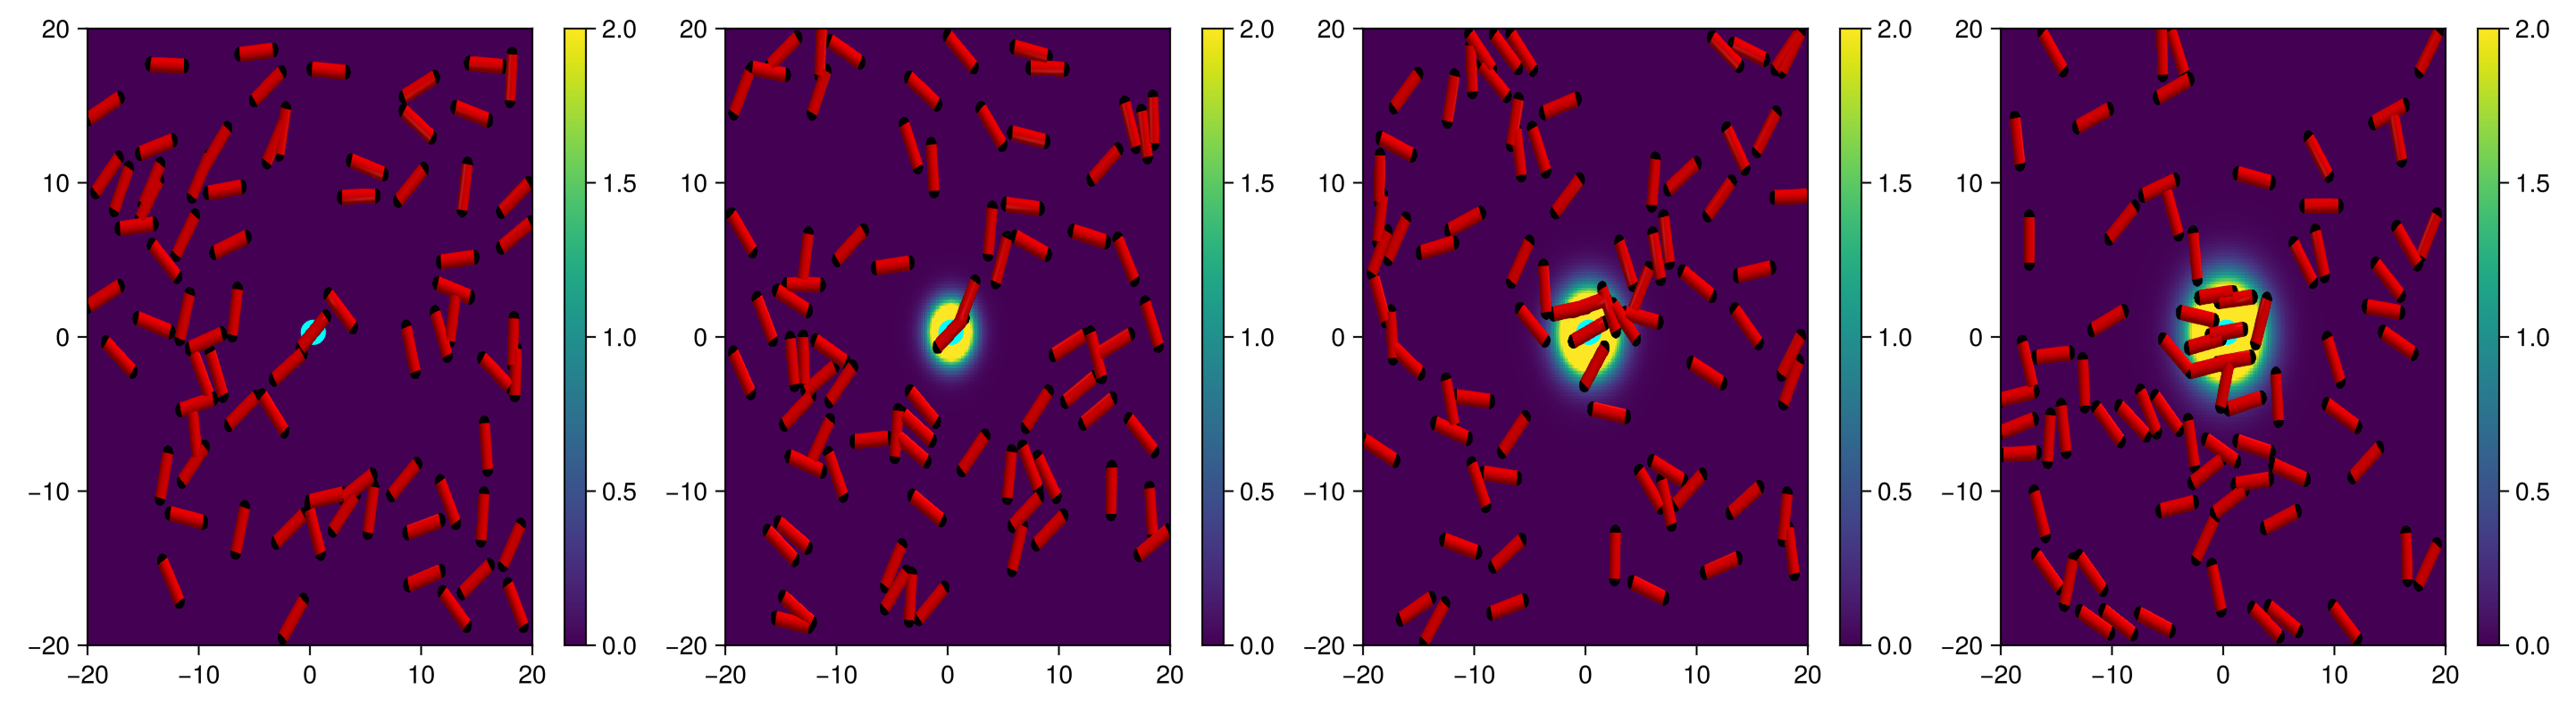

GLMakie.Screen(...)

In [27]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com_2)/4):length(com_2))
    begin
        d = getParameter(com_2, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com_2.simBox[1,1],com_2.simBox[1,2],length=size(com_2.mm)[1]),
                range(com_2.simBox[2,1],com_2.simBox[2,2],length=size(com_2.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com_2.simBox[1,:]...)
        ylims!(com_2.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

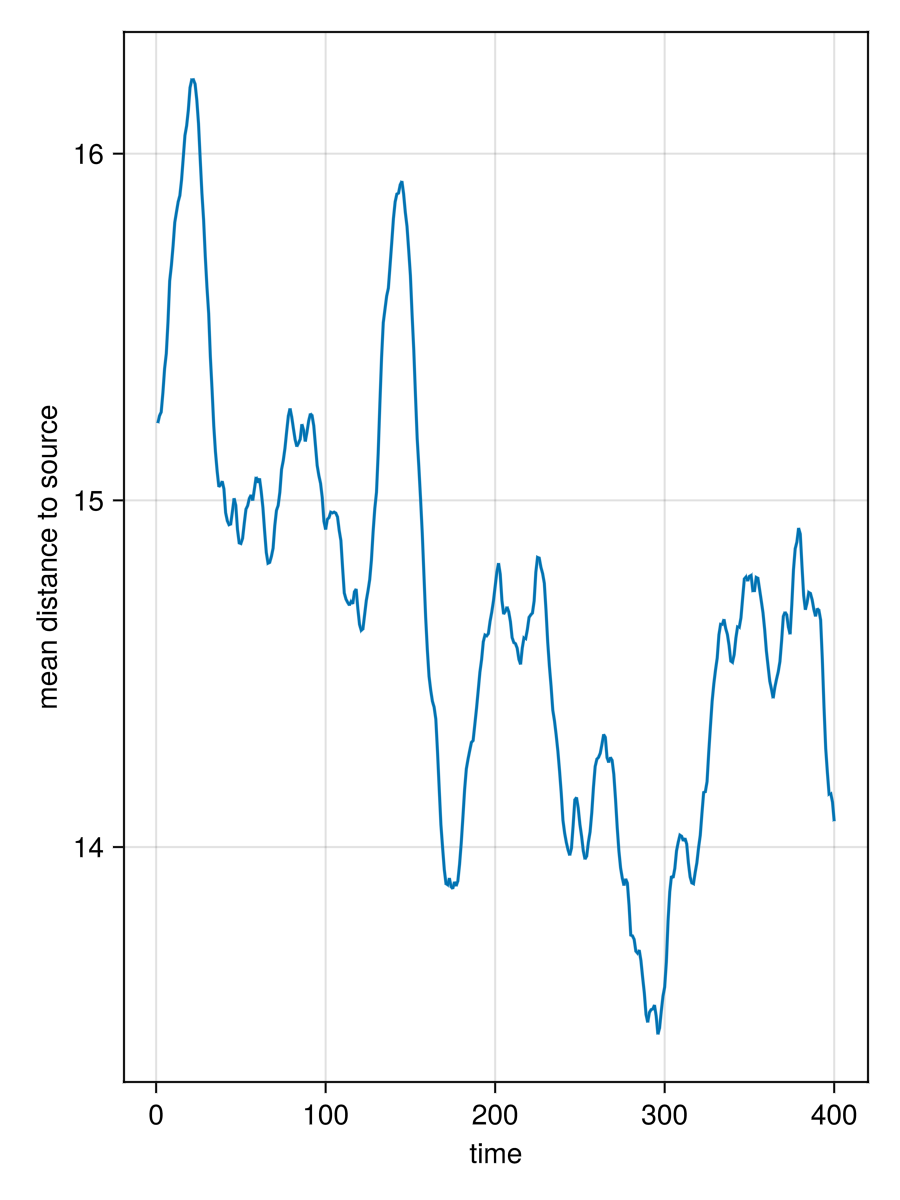

GLMakie.Screen(...)

In [28]:
using Statistics

d = getParameter(com_2, [:x, :y, :S, :isSource])

src_id = findfirst(d[:isSource][1])

t = [pt.t for pt in com_2.pastTimes]

# mean distance to source
mean_dist = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id]).^2 .+
            (d[:y][k] .- d[:y][k][src_id]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]

fig = Figure(size=(450, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, t, mean_dist)

display(fig)
